### Libraries

In [2]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

#### Function to extract the location from the tweets using carmen

In [3]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location

#### Function to get the country info from the location object

In [4]:
def getCountry(t):
    if(t):
        return t[1].country
    return None

### Reading the tweets and updating their geodata

In [5]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
full_dir = main_dir + 'data_full/'
id_dir   = main_dir + 'data/'

location_list = []
text_list = []
time_list = []

for file in sorted(os.listdir(full_dir))[:-2]:
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file)
    
    df_full['locations'] = df_full.apply(getLocation, axis = 1)
    df_full[['id', 'locations']].to_csv(full_dir + 'locations/' + file[:-9] + '_loc.csv', index = None)

    text_list.append(df_full[['id', 'full_text']])
    time_list.append(df_full[['id', 'created_at']])
    location_list.append(df_full[['id', 'locations']])
    
    print(file + ' ..done')
    print()
    

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv
05-07-2020_full.csv ..done

reading... 05-08-2020_full.csv
05-08-2020_full.csv ..done

reading... 05-09-2020_full.csv
05-09-2020_full.csv ..done

reading... 05-10-2020_full.csv
05-10-2020_full.csv ..done

reading... 05-11-2020_full.csv
05-11-2020_full.csv ..done

reading... 05-12-2020_full.csv
05-12-2020_full.csv ..done

reading... 05-13-2020_full.csv
05-13-2020_full.csv ..done

reading... 05-14-2020_full.csv
05-14-2020_full.csv ..done

reading... 05-15-2020_full.csv
05-15-2020_full.csv ..done

reading... 05-16-2020_full.csv
05-16-2020_full.csv ..done

reading... 05-17-2020_full.csv
05-17-2020_full.csv ..don

### Merging all the data

In [6]:
df_time = pd.concat(time_list).reset_index().drop('index', axis = 1)
df_text = pd.concat(text_list).reset_index().drop('index', axis = 1)
df_locations = pd.concat(location_list).reset_index().drop('index', axis = 1)

### Temporal frequency of tweets

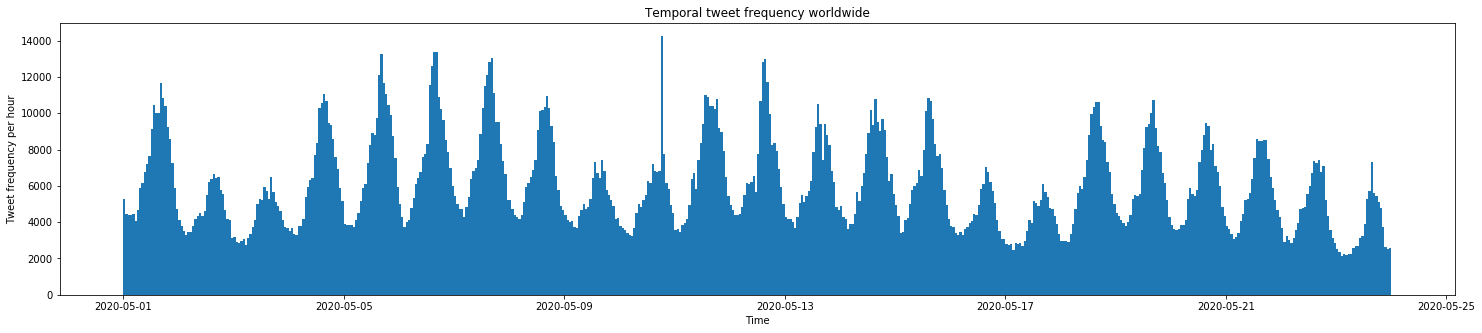

In [8]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df_time.created_at), bins = 24*len(time_list))
plt.savefig(main_dir + 'outputs/temporal_tweet_freq.png')
plt.show()

### Spatial frequency of tweets

In [9]:
locs = df_locations.locations.apply(getCountry).dropna()
country_df = pd.DataFrame.from_dict(Counter(locs), columns = ['count'], orient = 'index').reset_index()
country_df.columns = ['country', 'count']
codes_df = pd.read_csv('country_codes.csv')

code_freq_df = pd.merge(country_df, codes_df, on = 'country', how = 'left')
code_freq_df.to_csv(main_dir + 'data_full/locations/country_frequency.csv', index = None)
code_freq_df.head()

,country,count,code
0,United States,851478,USA
1,Nigeria,50260,NGA
2,India,240519,IND
3,United Kingdom,269596,GBR
4,Saudi Arabia,3555,SAU


In [10]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

world = world[['name', 'iso_a3', 'geometry']]
world.columns = ['country', 'code', 'geometry']
world.head()

,country,code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


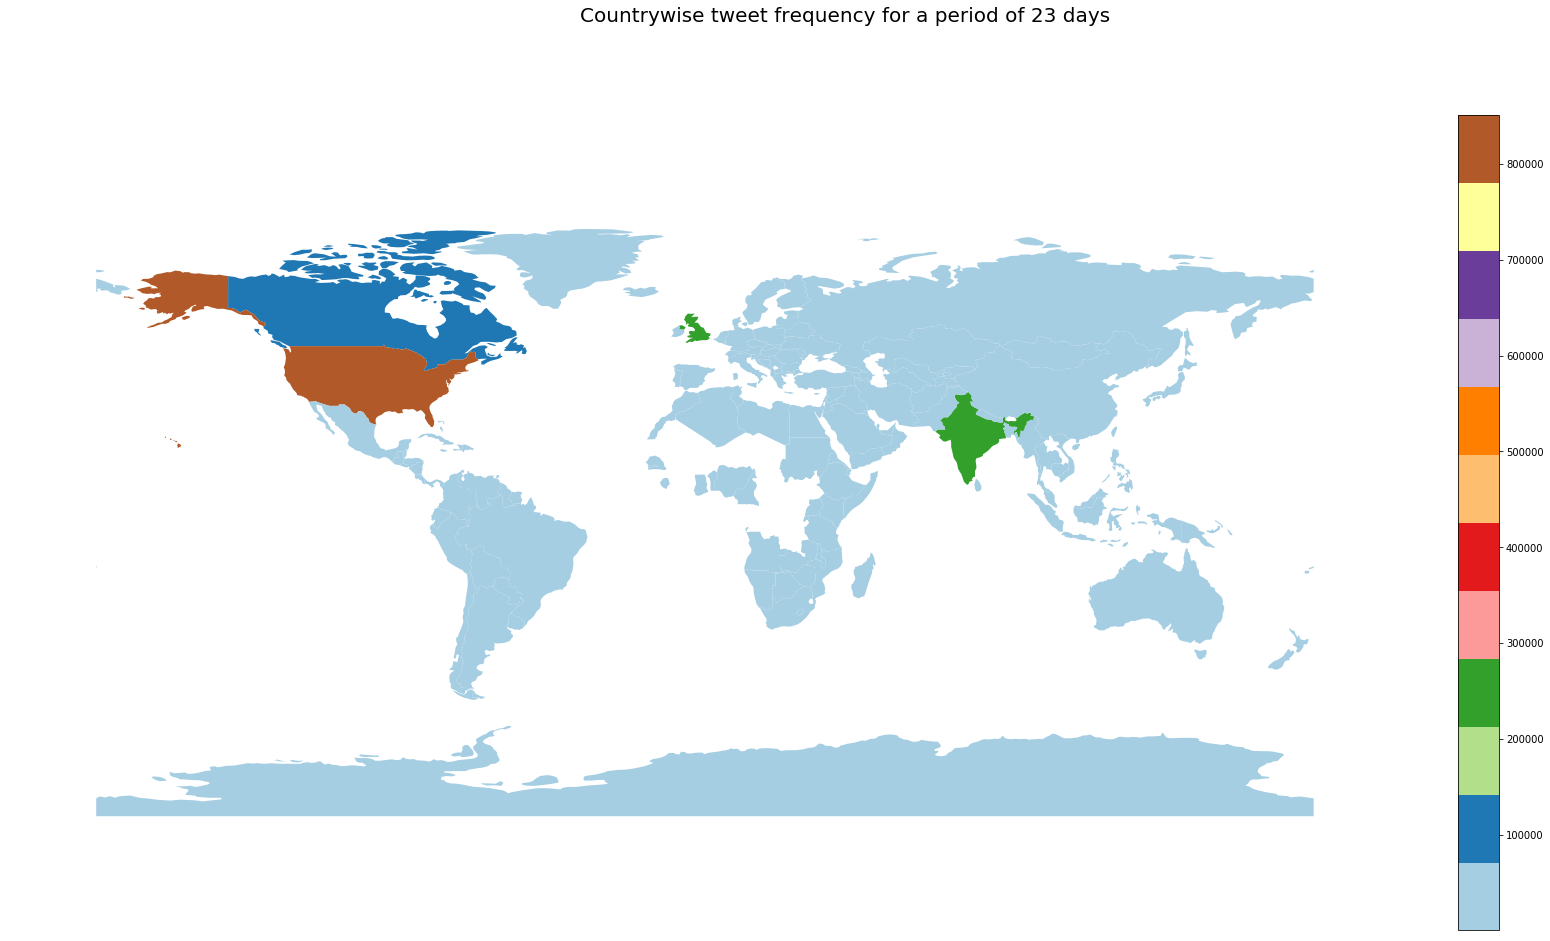

In [11]:
country_freq_df = pd.merge(world, code_freq_df, on='code')

fig, ax = plt.subplots(1, figsize=(30,15))
fig.suptitle('Countrywise tweet frequency for a period of ' + str(len(time_list)) + ' days', fontsize = 20)
ax.axis('off')
country_freq_df.plot(ax=ax, column='count', legend=True, cmap = 'Paired')
plt.savefig(main_dir + 'outputs/country_tweet_freq.png')

### Picking out the tweet texts

In [12]:
text_en = df_text['full_text']
print(text_en.iloc[0])

As a response to COVID19, 30% of companies surveyed are offering a home office stipend, 6% are giving stipends for child care, &amp; another 9% are giving money for takeout meals. How are you supporting your WFH workforce? https://t.co/JqtUm7d3gg 

 #SequoiaHR #HR #Business #COVID19


### Removing URLs from tweets

In [ ]:
def multiplyWithRetweetCount(text_list, retweet_count):
    f = 0
    if(np.isnan(retweet_count)):
        f = 1
    else:
        f = int(retweet_count + 1)

    return text_list*f


def cleanText(tweet, stem = False):
    text = tweet.full_text
    # Removing urls
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    
    # Removing user mentions
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)

    # Converting to lowercase
    text = text.lower()

    # Removing punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    text_list = text.split()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19'])
    
    text_list = [word for word in text_list if word not in stop_words]
    
    if stem:
        stemmer = SnowballStemmer('english')
        text_list = [stemmer.stem(t) for t in text_list]
    
    text_list = multiplyWithRetweetCount(text_list, tweet.retweet_count)
    return ' '.join(text_list)


### Converting all tweets to lowercase

In [ ]:
text_en_lr_lc.head()
print(text_en_lr_lc.iloc[0])

### Removing punctuations

In [ ]:
text_en_lr_lc_pr.head()
print(text_en_lr_lc_pr.iloc[0])

### Removing stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['coronavirusoutbreak', 'coronaviruspandemic', 'covid19', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'pandemic'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()
print(text_en_lr_lc_pr_sr.iloc[0])

### Concatenating all the tweets into a list of words

In [ ]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

### Calculating the Term Frequency

In [ ]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig(main_dir + 'outputs/wordcount_bar.png')

In [ ]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig(main_dir + 'outputs/wordcloud.png')



## Sentiment Analysis

### Getting the polarity scores for each tweet

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores)).reset_index().drop('index', axis = 1)

sent_scores_df['country'] = df_locations['locations'].apply(getCountry)

sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

### Plotting the sentiment score counts

In [ ]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig(main_dir + 'outputs/sentiment.png')

### Temporal plot of the sentiments

In [ ]:
sentiments_time_df = pd.DataFrame()
sentiments_time_df['time'] = df_time['created_at']
sentiments_time_df['polarity'] = sent_scores_df['compound']
# sentiments_time_df.index = pd.to_datetime(sentiments_time_df['time'])


ot = sentiments_time_df.sample(frac=.001)
ot['time'] = pd.to_datetime(ot['time'])
ot.index = pd.to_datetime(ot['time'])
ot.sort_index(inplace=True)
ot['expanding'] = ot['polarity'].expanding().mean()
ot['rolling'] = ot['polarity'].rolling('1h').mean()

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(ot['time'],ot['polarity'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['time'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['time'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,1),dt.date(2020,5,9)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.savefig(main_dir + 'outputs/temporal_sentiments.png')


### Sentiment scores distribution

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time_df['polarity'], bins=30, ax=ax)
# plt.show()
plt.savefig(main_dir + 'outputs/sentiment_distribution.png')

### Sentiment scores countrywise 

In [ ]:
sent_country_df = sent_scores_df[['compound', 'country']]
sent_means_df = sent_country_df.groupby('country').mean().reset_index()

mean_country_df = pd.merge(sent_means_df, codes_df, on = 'country', how = 'left')
mean_loc_df = pd.merge(world, mean_country_df, on = 'code', how = 'inner')
mean_loc_df = mean_loc_df[['compound', 'code', 'geometry']]
mean_loc_df.tail()



In [ ]:
fig, ax = plt.subplots(1, figsize=(30,15))
ax.axis('off')
fig.suptitle('Mean sentiment scores distribution worldwide for a period of ' + str(len(time_list)) + ' days', fontsize = 20)
mean_loc_df.plot(ax=ax, column='compound', legend=True, cmap = 'coolwarm')
plt.savefig(main_dir + 'outputs/country_mean_sent.png')

### Word cloud of polar words

In [ ]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)

axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig(main_dir + 'outputs/joint_cloud.png')

